In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from itertools import product

In [4]:
from commons import lse

In [5]:
fontsize = 14

# Loading the data

## $N_i(t)$

In order to compute the $\rho_i(t)$ as to compare them with their predictions, we first load the $N_i(t)$, which we smoothen accordingly :

In [6]:
Nt = np.moveaxis(np.load("synthetic-data.npy"), 1, 3)

## $\rho_i(t)$

We then first calculate the discrete derivatives $\frac{\Delta N_i(t)}{\Delta t} = \Delta N_i(t) = N_i(t+1) - N_i(t)$

In [7]:
dNdt = Nt[..., 1:] - Nt[..., :-1]

and then the $\rho_i(t) = \frac{\Delta N_i(t)}{N_i(t)}$

In [8]:
rho = dNdt / Nt[..., :-1]

## $\hat\rho_i(t)$

Then we load the predicted $\hat\rho_i(t)$ from the various models.

First the population-specific $\hat\rho_i(t) = \alpha_i(t) \; \epsilon(t)$ model :

In [9]:
ae = np.load("predictions/level-2_alpha-epsilon.npy")

Then the location-and-population-specific $\hat\rho_i(t) = \alpha_i(t) \; \epsilon_k(t)$ model :

In [10]:
aek = np.load("predictions/level-2_alpha-epsilon_k.npy")

Then the density-dependent $\hat\rho_i(t) = \alpha_i(t) \; \epsilon_k(t) \; \phi(N_i(t))$ model :

In [11]:
aep = np.load("predictions/level-2_alpha-epsilon_k-phi.npy")

Finally the diffusion model $\hat\rho_i(t) = \alpha_i(t) \; f(s(x_i, t))$ :

In [12]:
diff = np.load("predictions/level-3_diffusion.npy")

Additionally, we load the ML model $x_i, N_i(t) \mapsto \rho_i(t)$ :

In [13]:
ml = np.load("predictions/level-1_position-Nt.npy")

# Computations

## Dimensions

We get the dimensions of the data :

In [14]:
n_plates, n_rows, n_columns, n_points = rho.shape
plates, rows, columns, points = map(np.arange, rho.shape)

## Null model

We also compute here the null model $\hat\rho_i(t) = \epsilon(t) = \bar\rho(t)$ :

In [15]:
null = rho.reshape((n_plates, -1, n_points)).mean(axis = 1)

## Errors

We now compute the errors of each model by using the euclidean distance for each population $i$ along its time series :

In [16]:
_null = np.empty((n_plates, n_points))
_ae, _aek, _aep, _diff, _ml = _null.copy(), _null.copy(), _null.copy(), _null.copy(), _null.copy()

for p, t in product(plates, points):
    _null[p, t] = lse(rho[p, ..., t].reshape(-1), null[p, t])
    _ae[p, t] = lse(rho[p, ..., t].reshape(-1), ae[p, ..., t].reshape(-1))
    _aek[p, t] = lse(rho[p, ..., t].reshape(-1), aek[p, ..., t].reshape(-1))
    _aep[p, t] = lse(rho[p, ..., t].reshape(-1), aep[p, ..., t].reshape(-1))
    _diff[p, t] = lse(rho[p, ..., t].reshape(-1), diff[p, 3:-3, 3:-3, t].reshape(-1))
    _ml[p, t] = lse(rho[p, ..., t].reshape(-1), ml[p, ..., t].reshape(-1))

# Figure

We group the error data and its names :

In [17]:
errors = (_null, _ae, _aek, _aep, _diff, _ml)
names = ("null model", r"$\alpha$ $\epsilon$ model", r"$\alpha$ $\epsilon_k$ model", r"$\alpha$ $\epsilon_k$ $s$ model", "diffusion model", "random forest model")

Change the variable `p` in order to generate the figure for other plates

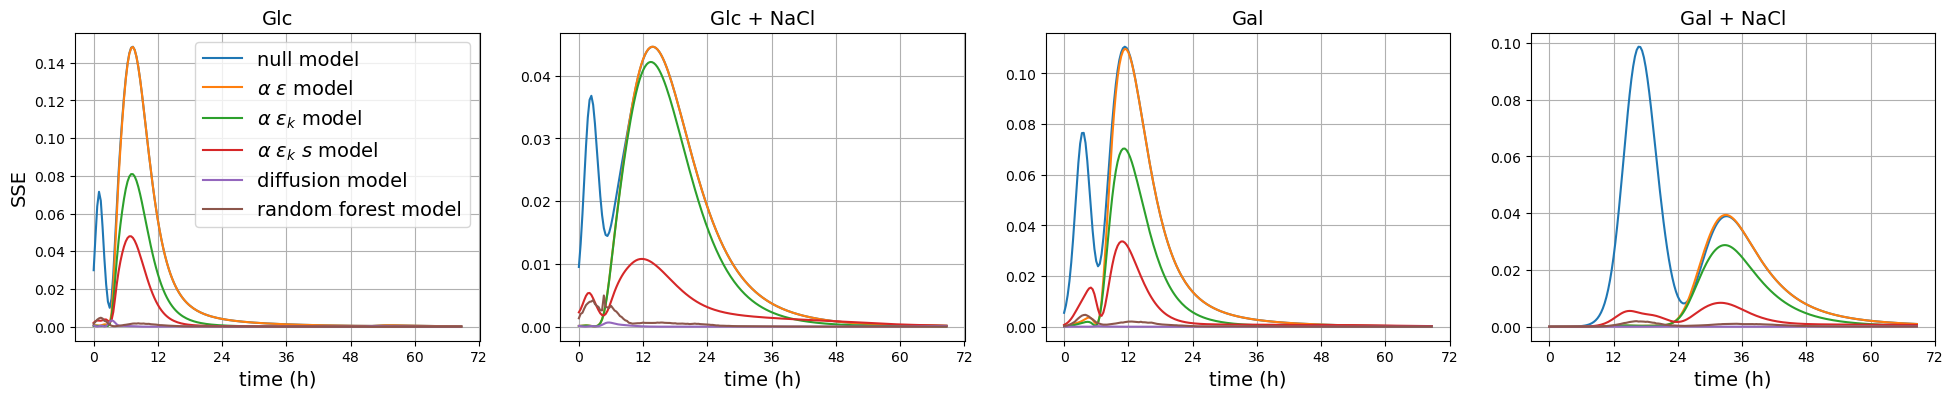

In [19]:
fig, axes = plt.subplots(ncols = n_plates, figsize = (24, 4))

indexes = [1, 2, 3, 0]
titles = ["Glc", "Glc + NaCl", "Gal", "Gal + NaCl"]

for p, env, ax in zip(indexes, titles, axes):
    for name, err in zip(names, errors):
        ax.plot(err[p], label = name)
    ax.grid()
    ax.set_title(env, fontsize = fontsize)
    ax.set_xlabel("time (h)", fontsize = fontsize)
    ax.set_xticks([0, 36, 72, 108, 144, 180, 216], labels = [0, 12, 24, 36, 48, 60, 72])
axes[0].set_ylabel("SSE", fontsize = fontsize)
axes[0].legend(fontsize = fontsize);

fig.savefig("plots/figure-s2/time-series.pdf", bbox_inches = "tight")
fig.savefig("plots/figure-s2/time-series.png", bbox_inches = "tight");